In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import os

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
np.random.seed(42)

In [3]:
"""
Read.me

전반적 흐름
1. train, test.csv읽어오기
2. X14, 16, 19를 삭제, 시간 데이터를 만드는 함수 생성
3. 풍향데이터를 cos데이터로 바꿔주기 (0도:1, 360도:-1)
4. train_df를 만들기 위해, x값들을 처리할 함수 생성 (묶여있는 데이터들의 평균값을 x, y로 설정)
5. train_df를 생성(x값을 1차가공, y값도 1차가공)
6. train_df를 train용, validation용으로 데이터 분류
7. LSTM모델 생성
8. LSTM모델 학습 & 그래프 생성
9. test_df를 생성
10. test데이터 분류, LSTM모델로 test데이터를 predict
11. 결과값을 submission.csv로 저장
"""

'\nRead.me\n\n전반적 흐름\n1. train, test.csv읽어오기\n2. X14, 16, 19를 삭제, 시간 데이터를 만드는 함수 생성\n3. 풍향데이터를 cos데이터로 바꿔주기 (0도:1, 360도:-1)\n4. train_df를 만들기 위해, x값들을 처리할 함수 생성 (묶여있는 데이터들의 평균값을 x, y로 설정)\n5. train_df를 생성(x값을 1차가공, y값도 1차가공)\n6. train_df를 train용, validation용으로 데이터 분류\n7. LSTM모델 생성\n8. LSTM모델 학습 & 그래프 생성\n9. test_df를 생성\n10. test데이터 분류, LSTM모델로 test데이터를 predict\n11. 결과값을 submission.csv로 저장\n'

In [4]:
#1

#csv파일 불러오기
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
    
#x칼럼 정리.
x_time = ['id'] #시간
x_temperature = ['X00', 'X07', 'X28', 'X31', 'X32'] #기온
x_local_pressure = ['X01', 'X06', 'X22', 'X27', 'X29'] #현지기압
x_wind_speed = ['X02', 'X03', 'X18', 'X24', 'X26'] #풍속
x_daily_rainfall = ['X04', 'X10', 'X21', 'X36', 'X39'] #일일 누적강수량
x_sealevel_pressure = ['X05', 'X08', 'X09', 'X23', 'X33'] #해면기압
x_daily_sun = ['X11', 'X34'] #일일 누적일사량 (X14, X16, X19는 제거됨)
x_humidity = ['X12', 'X20', 'X30', 'X37', 'X38'] #습도
x_wind_direction = ['X13', 'X15', 'X17', 'X25', 'X35'] #풍향

#y칼럼 정리
y_sensor = ['Y00', 'Y01','Y02','Y03','Y04', 'Y05', 'Y06', 'Y07', 'Y08', 
            'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17'] #센서측정온도
y_target = ['Y18'] #예측대상


#id값들을 시간형 데이터로 변경하는 함수 생성
def make_timedata(df):
    minute = (df['id'] % 144).astype(int)
    min_in_day = 24*6

    df['id'] = np.cos(np.pi * minute / min_in_day)
    print("id를 cos데이터로 변경 완료")

In [5]:
#2

#고장난 센서 X14, X16, X19 삭제
train = train.drop(['X14', 'X16', 'X19'], axis =1)
test = test.drop(['X14', 'X16', 'X19'], axis =1)
print('X14, X16, X19 삭제 완료')

train

X14, X16, X19 삭제 완료


,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,...,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,...,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,...,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,...,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,...,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,...,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4750,4750,19.4,987.7,0.9,0.8,0.0,1006.9,987.8,21.3,1007.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


In [6]:
#3

#풍향을 0은 1, 360은 -1로 가지는 값으로 변경
def make_wind_direction(df):
    df['X13'] = np.cos(df['X13'] * np.pi /360)
    df['X15'] = np.cos(df['X15'] * np.pi /360)
    df['X17'] = np.cos(df['X17'] * np.pi /360)
    df['X25'] = np.cos(df['X25'] * np.pi /360)
    df['X35'] = np.cos(df['X35'] * np.pi /360)
    print('풍향을 cos데이터로 변경 완료')
    
#wind_direction을 cos형 데이터로 변경
make_wind_direction(train)
make_wind_direction(test)

풍향을 cos데이터로 변경 완료
풍향을 cos데이터로 변경 완료


In [7]:
#4

"""
계산식을 변경하고 싶으면 
train[col_num].mean(axis = 1)를 변경해주세요. (초기 설정은 평균입니다)
"""

#train데이터에서 x값 대표를 만드는 함수. 일단은 x값들의 평균값.
def make_train_x(df, col_name, col_num=[]):
    df[col_name] = pd.Series(train[col_num].mean(axis = 1))

#train데이터에서 y값 대표를 만드는 함수. (평균)
def make_train_y(df, col_name, col_num=[]):
    df[col_name] = pd.Series(train[col_num].mean(axis = 1))

#test 데이터에서 x값 대표를 만드는 함수. 일단은 x값들의 평균값
def make_test_x(df, col_name, col_num=[]):
    df[col_name] = pd.Series(test[col_num].mean(axis = 1))

In [10]:
#5

#학습용 데이터프레임 생성
train_df = pd.DataFrame()

#id값 추가
train_df['id'] = train['id']

#id값을 시간형 데이터로 변경
make_timedata(train_df)

#X 대표값 추가
make_train_x(train_df, 'x_temperature', x_temperature)
make_train_x(train_df, 'x_local_pressure', x_local_pressure)
make_train_x(train_df, 'x_wind_speed', x_wind_speed)
make_train_x(train_df, 'x_daily_rainfall', x_daily_rainfall)
make_train_x(train_df, 'x_sealevel_pressure', x_sealevel_pressure)
make_train_x(train_df, 'x_daily_sun', x_daily_sun)
make_train_x(train_df, 'x_humidity', x_humidity)
make_train_x(train_df, 'x_wind_direction', x_wind_direction)

#Y값 추가 (30일의 Y값)
make_train_y(train_df, 'Y', y_sensor)

#Y0~17로 추정한 Y값(0:4320) 밑에 Y18(4320:)을 추가
train_df.iloc[4320:,9] = train.iloc[4320:,56]
train_df

id를 cos데이터로 변경 완료


,id,x_temperature,x_local_pressure,x_wind_speed,x_daily_rainfall,x_sealevel_pressure,x_daily_sun,x_humidity,x_wind_direction,Y
0,1.000000,10.62,998.24,0.74,0.0,1009.78,0.00,76.46,0.542385,10.666667
1,0.999762,10.42,998.28,0.80,0.0,1009.84,0.00,76.84,0.462046,10.444444
2,0.999048,10.26,998.26,0.80,0.0,1009.84,0.00,78.42,0.281470,10.166667
3,0.997859,10.12,998.22,0.50,0.0,1009.80,0.00,79.26,0.279828,10.000000
4,0.996195,10.00,998.24,0.50,0.0,1009.82,0.00,80.06,0.701712,9.833333
...,...,...,...,...,...,...,...,...,...,...
4747,-0.994056,20.44,996.22,0.76,2.7,1007.36,23.02,83.16,-0.355999,21.500000
4748,-0.996195,20.40,996.20,0.70,2.7,1007.34,23.02,83.72,-0.091188,21.500000
4749,-0.997859,20.34,996.24,0.46,2.7,1007.38,23.02,83.76,-0.128338,21.500000
4750,-0.999048,20.20,996.28,0.48,2.7,1007.44,23.02,84.10,-0.085199,21.500000


In [11]:
#6

"""
머신러닝을 위한 데이터 분류 과정

0~4320은 train용으로
4320~4752는 validation용으로 분할
"""

#학습용 x데이터와 y데이터로 분류
x_train = train_df.drop('Y',axis=1).iloc[:4320,:]
y_train = train_df[['Y']].iloc[:4320,:]

#데이터프레임에서 2차원 array로 변경
x_train = x_train.values
y_train = y_train.values


#검증용 x데이터와 y데이터로 분류
x_valid = train_df.drop('Y',axis=1).iloc[4320:,:]
y_valid = train_df[['Y']].iloc[4320:,:]

#데이터프레임에서 array로 변경
x_valid = x_valid.values
y_valid= y_valid.values

print(x_train.shape)
#2차원 array에서 딥러닝을 위해 3차원 array로 변경
x_train_t = x_train.reshape(x_train.shape[0] , 9, 1) 
x_valid_t = x_valid.reshape(x_valid.shape[0] , 9, 1)

(4320, 9)


In [29]:
import tensorflow as tf
import random as rn

seed_num = 42
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)


from keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)

tf.compat.v1.keras.backend.set_session(sess)

In [30]:
#7

"""
케라스 모델 생성
초기값 : LSTM(20), Dense(1)
"""

#딥러닝 모델 생성
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

#LSTM(20), loss = mse로 설정해서 mse를 줄이는 방향으로 모델 생성
model = Sequential()  
model.add(LSTM(20, input_shape=(9, 1))) # input_shape(timestep=몇개를 묶어서 볼것인가, feature = 변수가 몇개인가) 
model.add(Dense(1)) # output = 1
model.compile(loss='mean_squared_error', optimizer= 'adam')
model.summary()

#patience=val_loss가 5번의 Epoch동안 줄어들지 않으면, 조기종료. (과적합 방지를 위함)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


Train on 4320 samples, validate on 432 samples
Epoch 1/150
4320/4320 [==============================] - 4s 838us/step - loss: 458.6525 - val_loss: 432.1312
Epoch 2/150
4320/4320 [==============================] - 1s 293us/step - loss: 241.7476 - val_loss: 282.1752
Epoch 3/150
4320/4320 [==============================] - 1s 248us/step - loss: 168.2039 - val_loss: 211.1395
Epoch 4/150
4320/4320 [==============================] - 1s 253us/step - loss: 124.6388 - val_loss: 161.5582
Epoch 5/150
4320/4320 [==============================] - 1s 332us/step - loss: 95.9568 - val_loss: 126.3137
Epoch 6/150
4320/4320 [==============================] - 1s 284us/step - loss: 77.4347 - val_loss: 101.5667
Epoch 7/150
4320/4320 [==============================] - 2s 357us/step - loss: 65.9282 - val_loss: 84.5826
Epoch 8/150
4320/4320 [==============================] - 2s 535us/step - loss: 59.1722 - val_loss: 72.9073
Epoch 9/150
4320/4320 [==============================] - 2s 444us/step - loss: 55.4347 

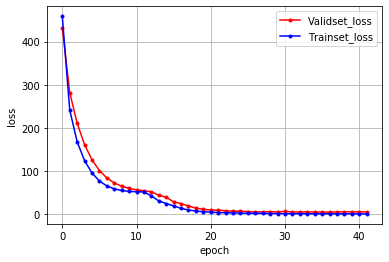

In [31]:
#8

history = model.fit(x_train_t, y_train, epochs=150, callbacks=[early_stop],
                    validation_data=(x_valid_t,y_valid))


#학습셋의 오차
y_loss = history.history['loss']

#테스트셋의 오차
y_vloss = history.history['val_loss']

# 결과 그래프 생성
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label="Validset_loss")
plt.plot(x_len, y_loss, marker='.', c="blue", label="Trainset_loss")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [11]:
#9

#테스트용 데이터프레임 생성
test_df = pd.DataFrame()

#id값 추가
test_df['id'] = test['id']

#id값을 시간형 데이터로 변경
make_timedata(test_df)

#X 대표값 추가
make_test_x(test_df, 'x_temperature', x_temperature)
make_test_x(test_df, 'x_local_pressure', x_local_pressure)
make_test_x(test_df, 'x_wind_speed', x_wind_speed)
make_test_x(test_df, 'x_daily_rainfall', x_daily_rainfall)
make_test_x(test_df, 'x_sealevel_pressure', x_sealevel_pressure)
make_test_x(test_df, 'x_daily_sun', x_daily_sun)
make_test_x(test_df, 'x_humidity', x_humidity)
make_test_x(test_df, 'x_wind_direction', x_wind_direction)

test_df

id를 cos데이터로 변경 완료


,id,x_temperature,x_local_pressure,x_wind_speed,x_daily_rainfall,x_sealevel_pressure,x_daily_sun,x_humidity,x_wind_direction
0,1.000000,19.94,996.18,0.80,0.0,1007.34,0.00,85.22,0.135868
1,0.999762,19.92,996.12,0.64,0.0,1007.28,0.00,85.52,0.080360
2,0.999048,19.90,996.06,0.64,0.0,1007.22,0.00,85.62,0.537055
3,0.997859,19.72,996.04,0.82,0.0,1007.20,0.00,86.18,0.295775
4,0.996195,19.68,996.08,0.66,0.0,1007.24,0.00,86.72,0.325592
...,...,...,...,...,...,...,...,...,...
11515,-0.994056,25.54,1001.72,3.12,0.1,1012.70,18.33,77.84,0.336183
11516,-0.996195,25.84,1001.70,3.10,0.1,1012.68,18.33,75.56,0.391283
11517,-0.997859,25.70,1001.74,3.26,0.1,1012.74,18.33,76.20,0.322226
11518,-0.999048,25.68,1001.72,2.76,0.1,1012.70,18.33,76.00,0.371843


In [12]:
#10

x_test = test_df
x_test= x_test.values
x_test_t = x_test.reshape(x_test.shape[0], 9, 1)

y_pred = model.predict(x_test_t)

In [13]:
#11

result = pd.DataFrame()
result["id"] = test["id"]
result["Y18"] = y_pred
result

result.to_csv("data/submission.csv", index=False)

In [14]:
"""
#X데이터 정규화
x_name = train_df.iloc[:,1:].columns


#스탠다드스케일러를 사용하여, X데이터를 N(0,1)정규화.
from sklearn.preprocessing import StandardScaler  

Scaler = StandardScaler()
train_X_normed = Scaler.fit_transform( train_df[x_name] ) 
test_X_normed = Scaler.transform(test_df[x_name])   

#train데이터와 test데이터에 저장.
train_df = pd.DataFrame(columns=x_name, data = train_X_normed)
test_df = pd.DataFrame(columns=x_name, data = test_X_normed)
"""

'\n#X데이터 정규화\nx_name = train_df.iloc[:,1:].columns\n\n\n#스탠다드스케일러를 사용하여, X데이터를 N(0,1)정규화.\nfrom sklearn.preprocessing import StandardScaler  \n\nScaler = StandardScaler()\ntrain_X_normed = Scaler.fit_transform( train_df[x_name] ) \ntest_X_normed = Scaler.transform(test_df[x_name])   \n\n#train데이터와 test데이터에 저장.\ntrain_df = pd.DataFrame(columns=x_name, data = train_X_normed)\ntest_df = pd.DataFrame(columns=x_name, data = test_X_normed)\n'

In [37]:
!pip install tensorflow-gpu==1.12.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==1.12.0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.2.0rc0, 2.2.0rc1)
ERROR: No matching distribution found for tensorflow-gpu==1.12.0
